# Вступление

Данная "тетрадка" посвящена изучению последних слогов в названиях населенных пунктов в Республике Татарстан.Также в процессе работы создан датасет со всеми населенными пунктами в республике с названием района,кодом ОКТМО и типом населенного пункта.
Разбор слова на слоги может быть неточным, возможно, в дальнейшем,я переделаю алгоритм на более научный.
# Разберем библиотеки, которые будем использовать:  
**re** - библиотека для работы с регулярные выражениями.  
**BeatifulSoup** - библиотека для парсинга HTML.  
**pandas** - Мастхэв, мощная библиотека для работы с табличными данными.  
**requests** - позволяет делать HTTP запросы в одну строчку кода.  
**folium** - питоновская обёртка поверх Leaflet.js.Позволяет создавать интерактивные карты,а также сохранить в .html формате.   
**matplotlib.pyplot** - визуализация чего угодно и в каком угодно виде :)  

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import folium
import matplotlib.pyplot as plt

plt.style.use('ggplot') 

Парсим сайт и вычленяем из каждой строки полезную для нас информацию- район,тип населенного пункта и код ОКТМО.

In [2]:
r=requests.get('http://www.oktmo.ru/locality_registry/?code=92000000000')
soup=BeautifulSoup(r.text,'lxml')

oktmo=[]
tip=[]
name=[]
k=0

for part in soup.find_all('p')[7:]:
    sr=re.search(r'<p><b>(.*)\(\d\)\.<\/b>\s(\w*\.)(.*)</p>',str(part))
    if sr!=None:
        if ('лесн.') not in str(sr.group(2)):
            if 'ж/д рзд' in str(sr.group(3)):
                tip.append('ж/д')
                name.append(str(sr.group(3)).replace('ж/д рзд','').lstrip().rstrip())
                oktmo.append(str(sr.group(1)))
            elif 'ж/д ст' in str(sr.group(3)):
                tip.append('ст.')
                name.append(str(sr.group(3)).replace('ж/д ст','').lstrip().rstrip())
                oktmo.append(str(sr.group(1)))
            else:
                name.append(str(sr.group(3)).rstrip().lstrip())
                tip.append(str(sr.group(2)).rstrip().lstrip())
                oktmo.append(str(sr.group(1)))

Мной остались проигнорированы Бутинское лесничество в Альметьевском районе и ж/д разъезд Сарай-Чекурча в Арском районе. Пофикшу это в скором времени

# Расшифровка аббревиатур
Данные в спиcке tip представлены в качестве сокращений. Расшифруем их и создадим DataFrame для дальнейшей работы с данными

In [3]:
set(tip)

{'г.', 'д.', 'ж/д', 'п.', 'пгт.', 'с.', 'ст.'}

In [4]:
def replace_abbr(element):
    if element=='г.':
        return 'город'
    elif element=='д.':
        return 'деревня'
    elif element=='п.' or element=='ст.' or element=='ж/д':
        return 'поселок'
    elif element=='пгт.':
        return 'поселок городского типа'
    elif element=='с.':
        return 'село'
    #elif element=='ст.':
        #return 'поселок станции'
    #elif element=='ж/д':
        #return 'поселок разъезда'

tip=list(map(replace_abbr,tip))

In [5]:
df=pd.DataFrame([oktmo,tip,name]).T
df.columns=['Код','Тип','Название']

ОКТМО - это общероссийский классификатор территорий муниципальных образований.   
Для каждого населенного пункта он разный, но есть одна общая вещь- у Республики Татарстан первые 2 цифры одни для всех-92.  
Следующие 3 цифры отражают район, в котором находится населенный пункт.  
Составим словарь и новый столбец 'Район',который получим почленным сопоставлением 2-4 символов кода ОКТМО каждого элемента с содержимым словаря.Приведем столбец с кодом к численному типу данных и сохраним датасет. Его можно найти в репозитории.

In [6]:
dict={'601':'Агрызский район','602':'Азнакаевский район','604':'Аксубаевский район','605':'Актанышский район',
      '606':'Алексеевский район','607':'Алькеевский район','608':'Альметьевский район','610':'Апастовский район',
     '612':'Арский район','613':'Атнинский район','614':'Бавлинский район','615':'Балтасинский район',
      '617':'Бугульминский район','618':'Буинский район','620':'Верхнеуслонский район','622':'Высокогорский район',
      '624':'Дрожжановский район','626':'Елабужский район','627':'Заинский район','628':'Зеленодольский район',
     '629':'Кайбицкий район','630':'Камско-Устьинский район','632':'Спасский район','633':'Кукморский район',
     '634':'Лаишевский район','636':'Лениногорский район','638':'Мамадышский район','639':'Менделеевский район',
     '640':'Мензелинский район','642':'Муслюмовский район','644':'Нижнекамский район','645':'Новошешминский район',
     '646':'Нурлатский район','648':'Пестречинский район','650':'Рыбно-Слободский район','652':'Сабинский район',
     '653':'Сармановский район','654':'Ютазинский район','655':'Тетюшский район','656':'Тюлячинский район',
      '657':'Тукаевский район','658':'Черемшанский район','659':'Чистопольский район','701':'Город Казань',
      '730':'Город Набережные Челны'}


In [7]:
df['Район']=df['Код'].map(lambda x:dict[x[2:5]])

In [8]:
df['Код']=df['Код'].astype('int64')

In [9]:
#df.to_excel('Татарстан_Населенные_Пункты.xlsx',index=False)

Напишем функцию деления слов на слоги.Алгоритм взят отсюда:https://slogi.su/pravila.html ,тот,который для традиционной школы.  
Применим её к каждому элементу столбца 'Название'.

In [9]:
def get_syl(word):
    #print(word)
    glas=['а','я','о','е','у','ю','ы','и','э','е']
    if ' ' in word:
        word=word.split()[-1]
    if '-' in word:
        word=word.split('-')[-1]
    if '"' in word:
        word=word.replace('"','')
    syl=[]
    u=0
    k=0
    start=0
    while k<=len(word)-1:
        #print(start)
        if word[k].lower() in glas:
            u=k+1
            f=0
            while u<=len(word)-1:
                if word[u].lower() in glas:
                    f=1
                    break
                u=u+1
            if f!=1:
                syl.append(word[start:])
                k=len(word)
                start=len(word)
            else:
                if word[k+1].lower() in ['ъ','ь','й']:
                    syl.append(word[start:k+2])
                    start=k+2
                    k=k+2
                else:
                    if k+2<=len(word)-1 and word[k+2].lower() in ['ь','ъ','й']:
                        syl.append(word[start:k+3])
                        start=k+3
                        k=k+3
                    else:
                        syl.append(word[start:k+1])
                        start=k+1
                        k=k+1
        else:
            k=k+1
    if syl==[]:
        syl=word
    return syl[-1]

In [10]:
df['Слог']=df['Название'].map(get_syl)

Решил добавить немного визуализации. По первому графику можно сделать вывод, что основная масса населенных пунктов РТ - села и поселки. Вторая столбчатая диаграмма показывает общее количество населенных пунктов в разных муниципальных районах, а третья - структуру каждого муниципального района.

Text(0.5, 1.0, 'Распределение населенных пунктов в Республике Татарстан по их типам')

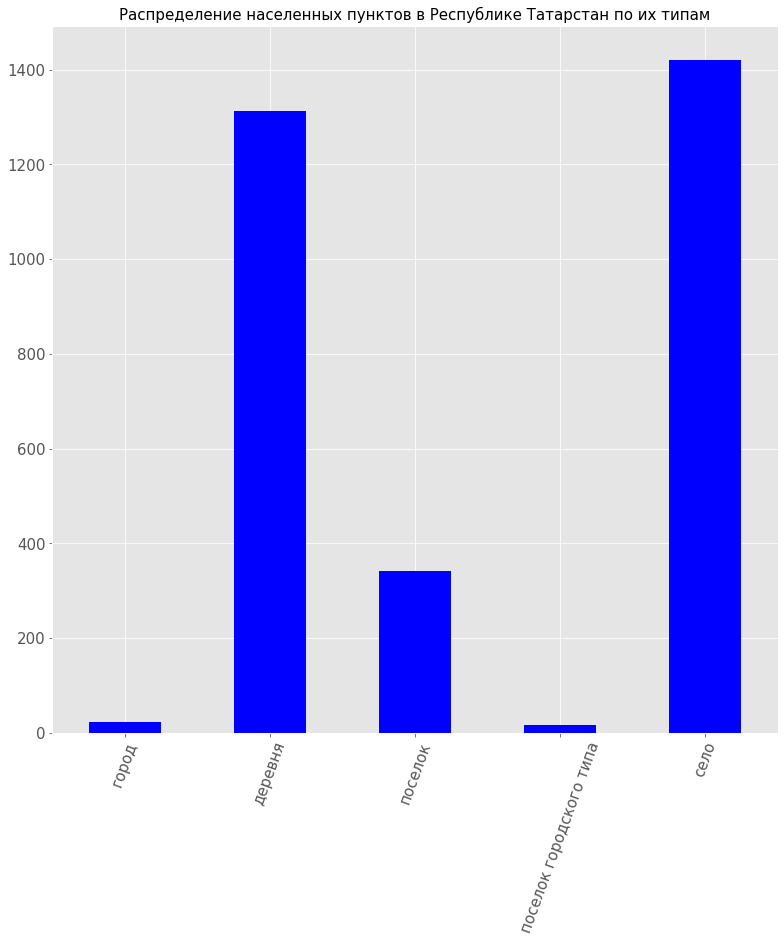

In [11]:
df.groupby('Тип').size().plot.bar(figsize=(13,13),fontsize=15,color='b')
plt.xticks(rotation=70)
plt.xlabel('')
plt.title('Распределение населенных пунктов в Республике Татарстан по их типам',fontsize=15)

Text(0.5, 1, 'Общее количество населенных пунктов(по районам Республики Татарстан)')

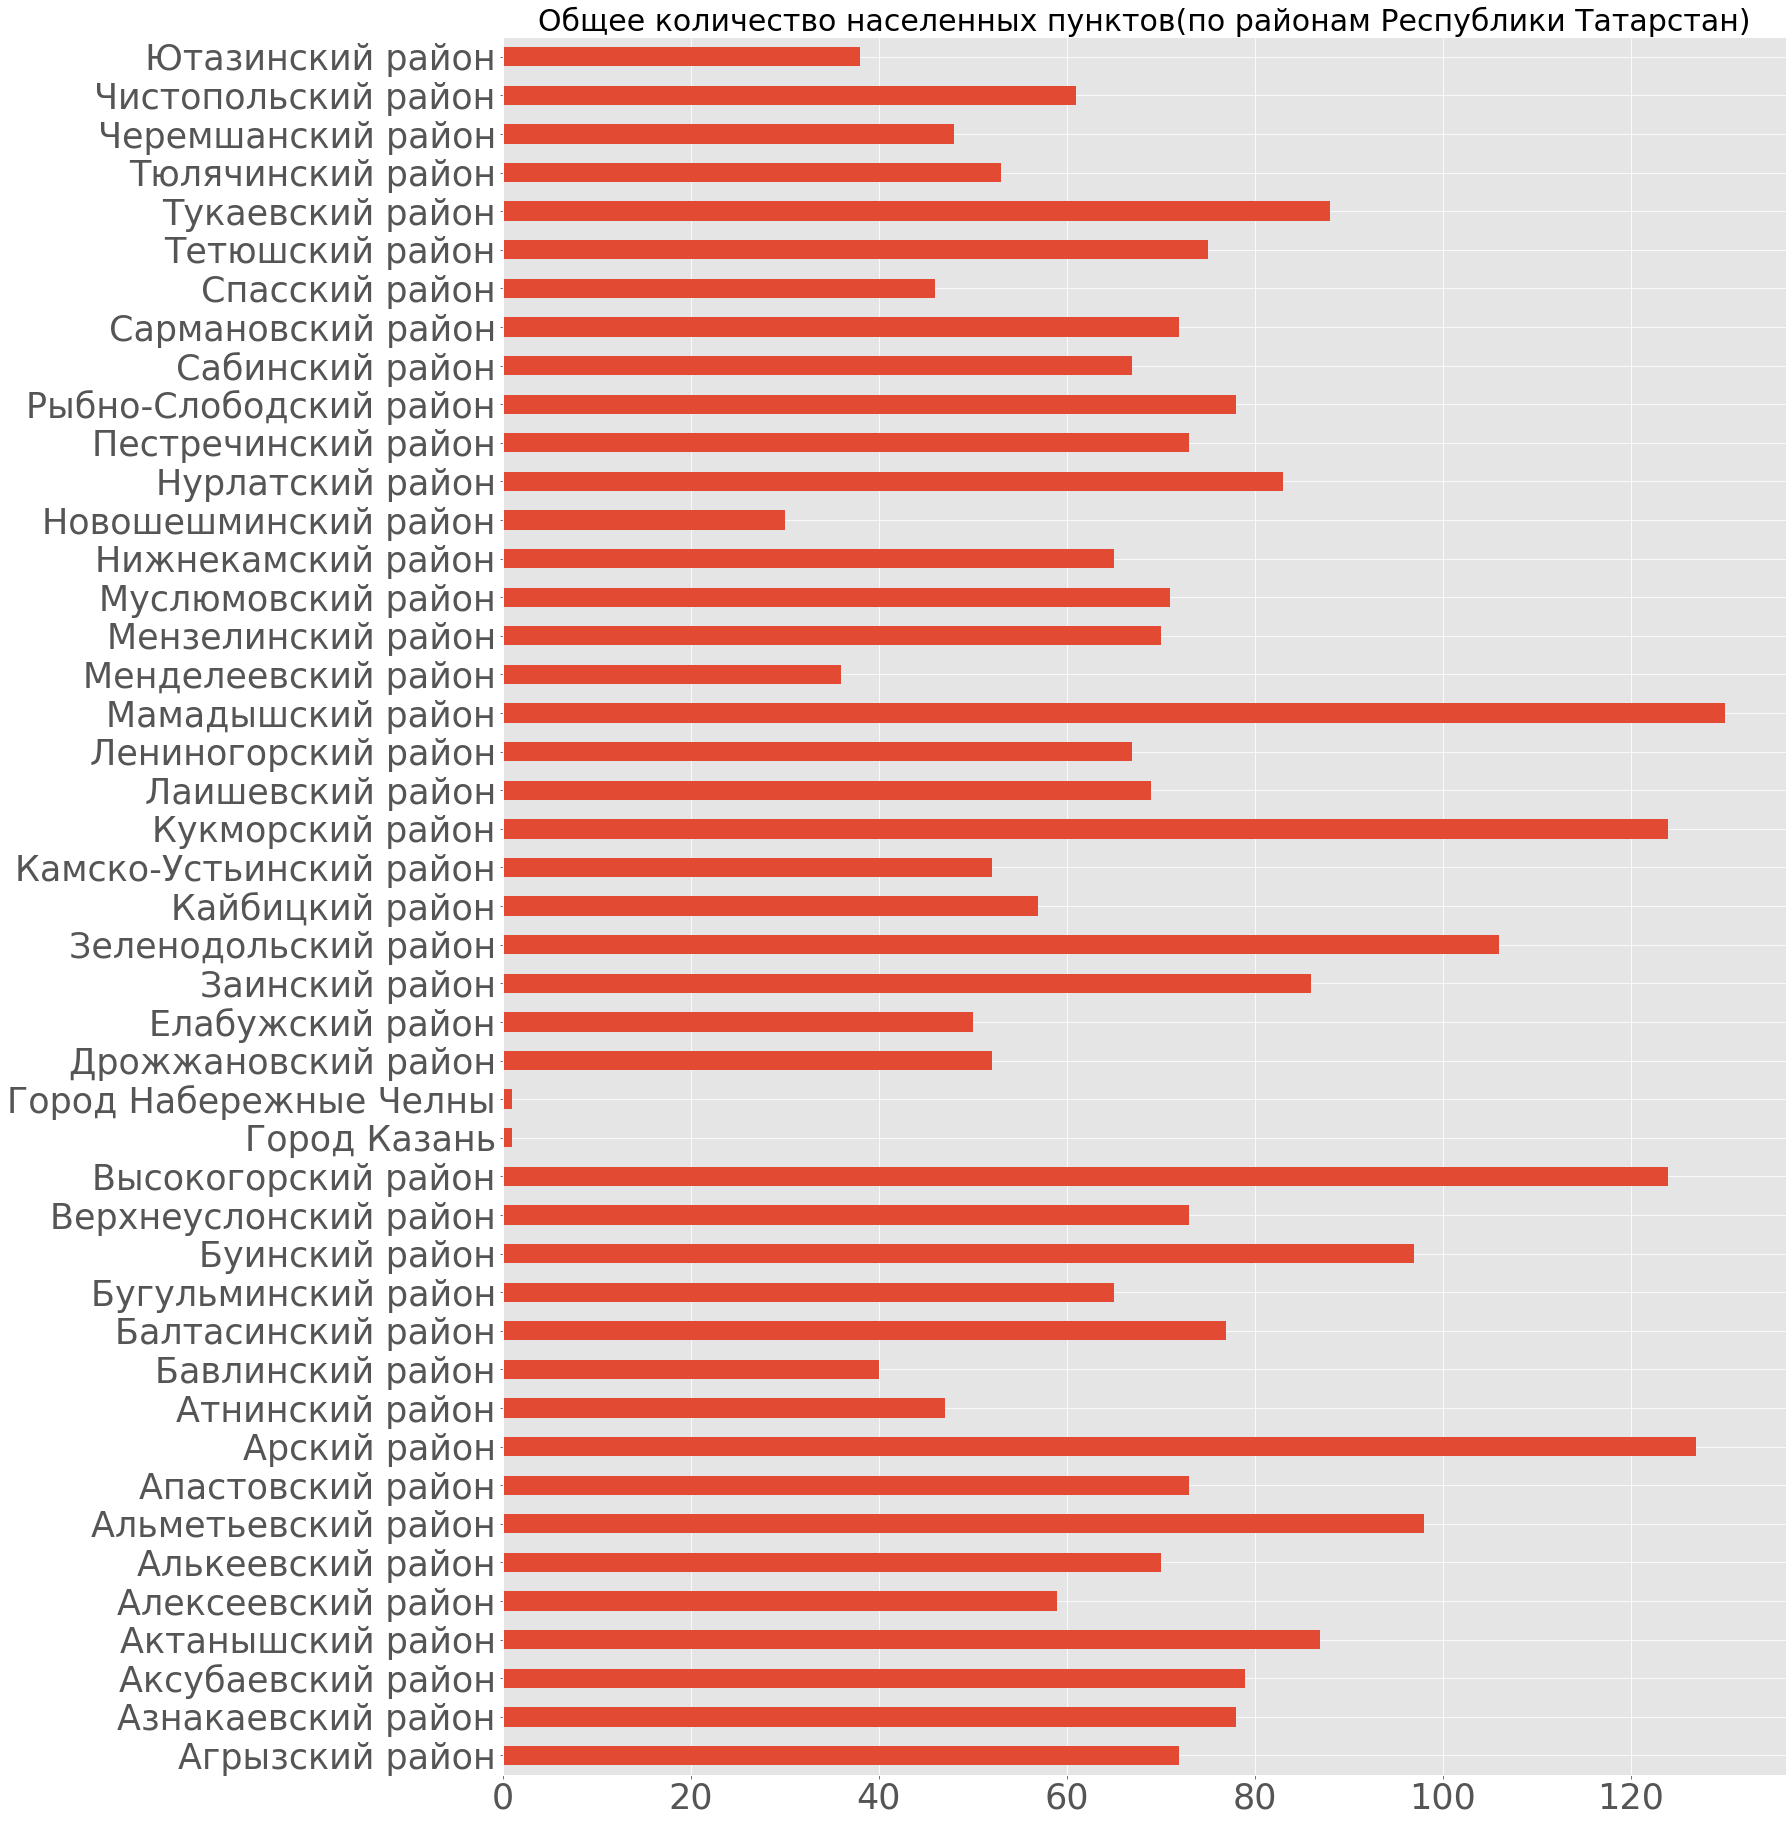

In [12]:
df.groupby('Район').size().plot.barh(figsize=(25,25),fontsize=35)
plt.ylabel('')
plt.tight_layout()
plt.title('Общее количество населенных пунктов(по районам Республики Татарстан)',fontsize=30)

Text(0.5, 1, 'Типовой состав населенных пунктов(по районам Республики Татарстан)')

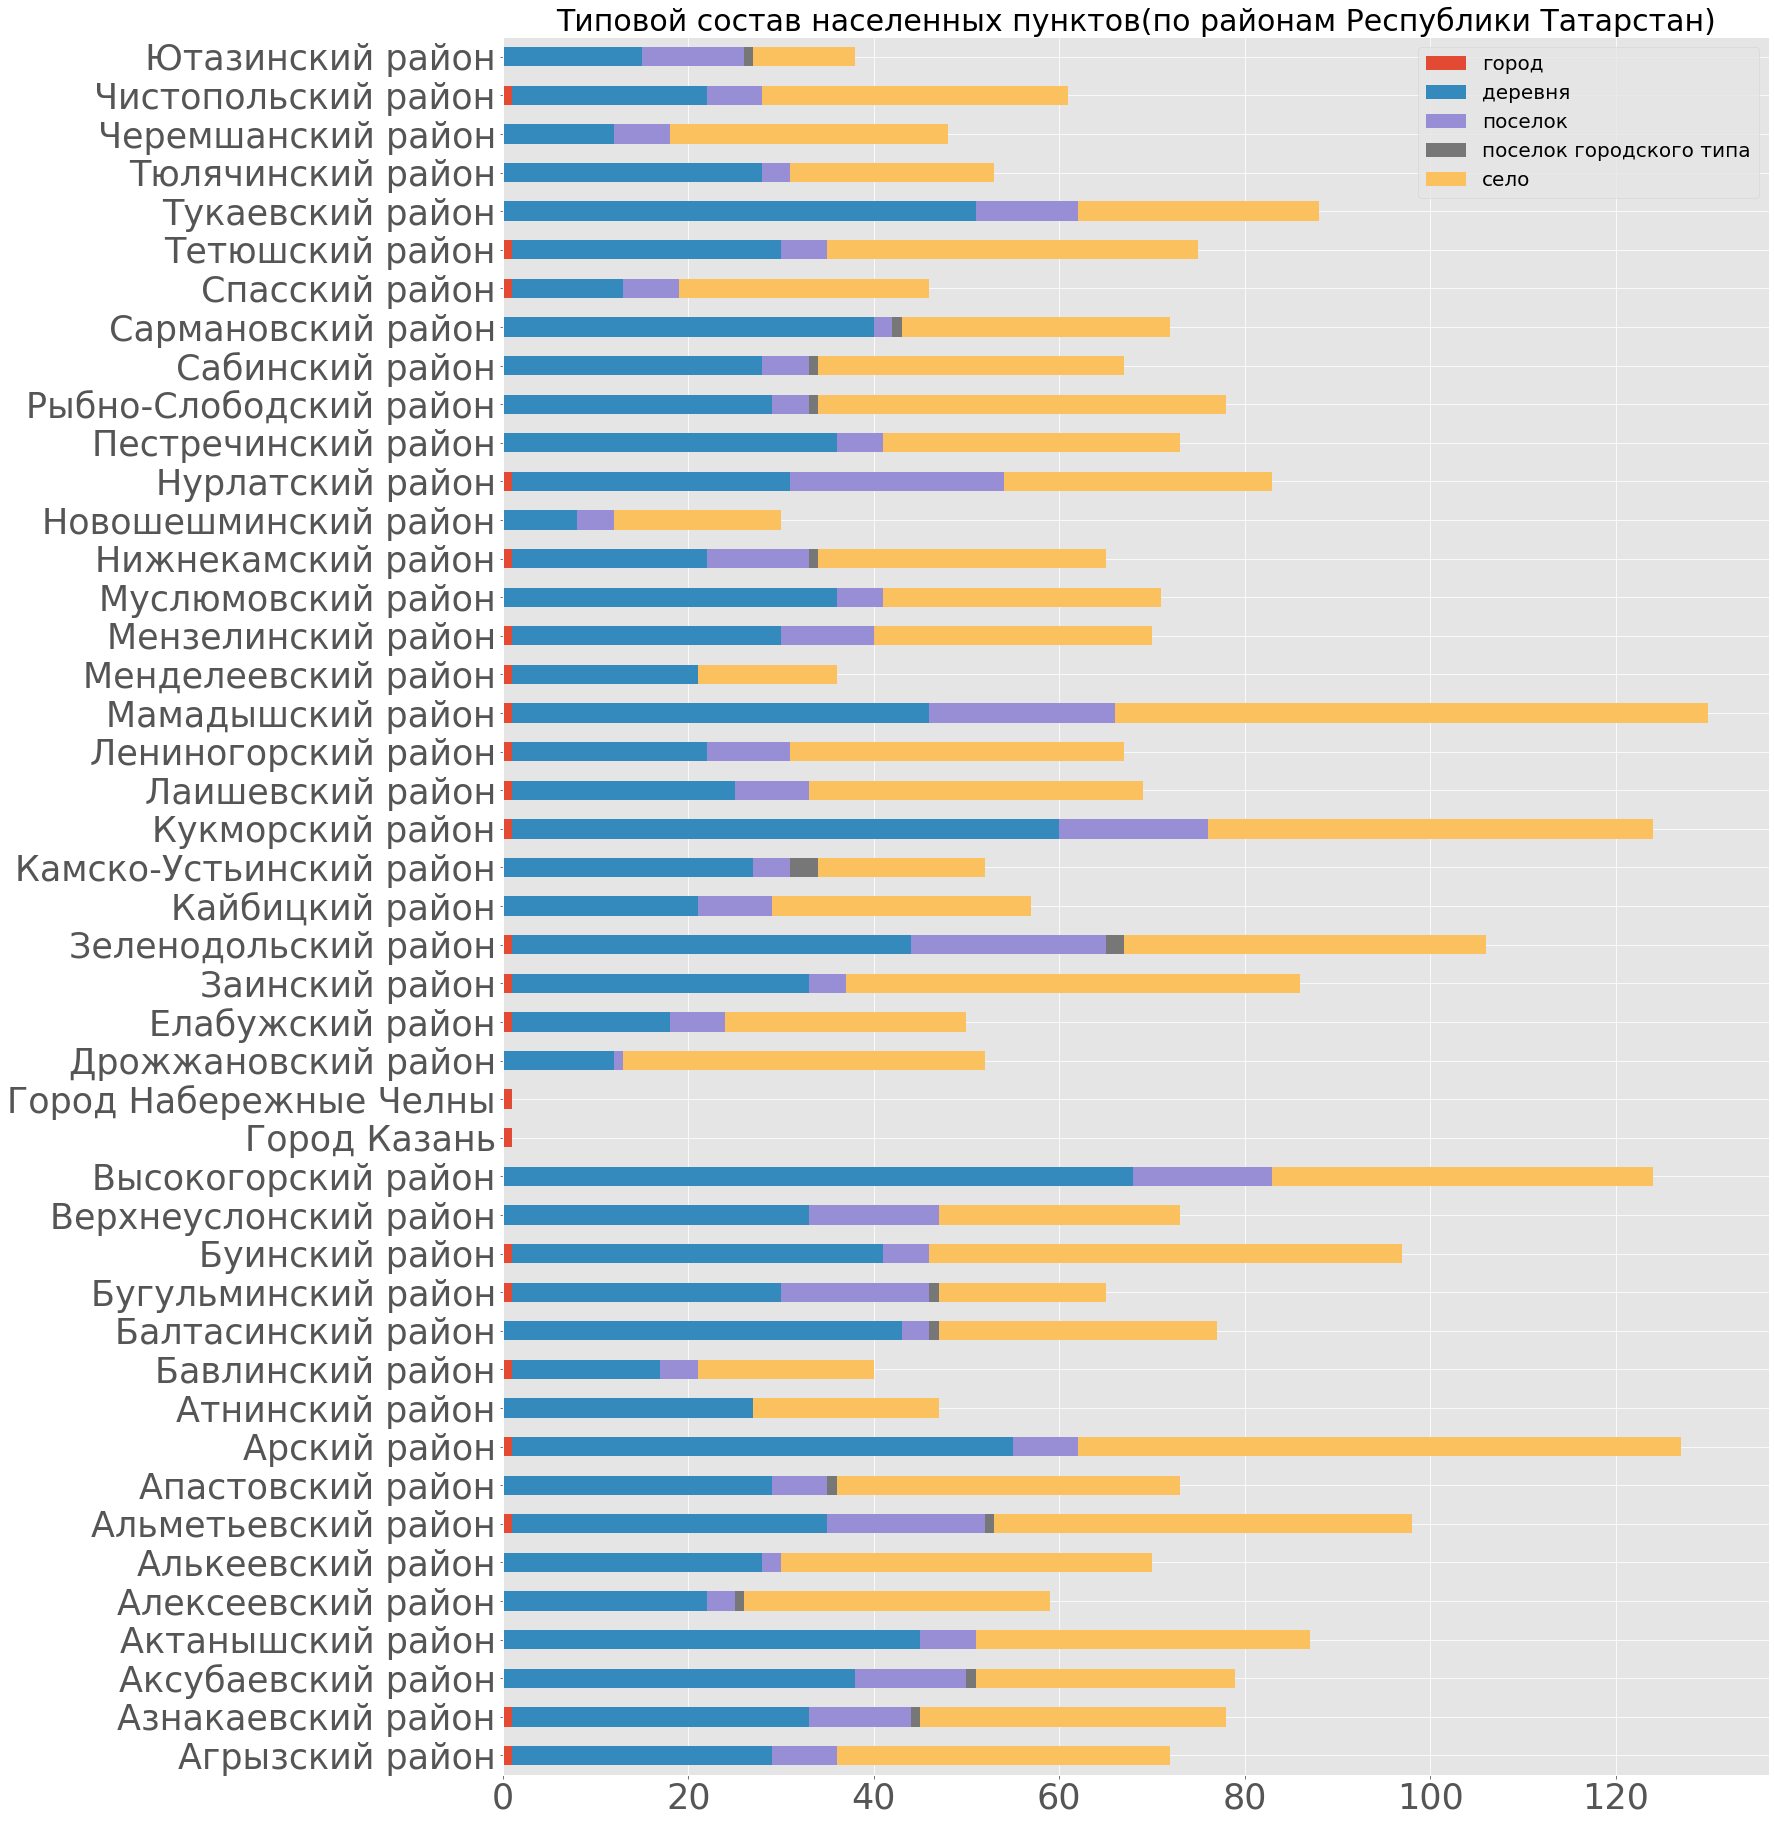

In [13]:
t=df.groupby('Район')['Тип'].value_counts().unstack()
t.fillna(0,inplace=True)
t.plot.barh(stacked=True,figsize=(25,25),fontsize=35)
plt.legend(fontsize=20)
plt.tight_layout()
plt.ylabel('')
plt.title('Типовой состав населенных пунктов(по районам Республики Татарстан)',fontsize=30)

Слогов получилось очень много. Решил ограничиться ТОП-30.

In [14]:
freq_syl=list(df['Слог'].value_counts().nlargest(30).index)
df_temp=df[df['Слог'].isin(freq_syl)]

Выделим 2 отдельные таблицы.Точнее,отделим населенные пункты,которые находятся в одном районе и имеют идентичные названия-с ними будем работать отдельно.  
Также заменим в некоторых названиях "им" на "имени".

In [15]:
df_temp.loc[df_temp['Название'].str.contains('им '),'Название']=df_temp.loc[df_temp['Название'].str.contains('им ')]['Название'].str.replace('им ','имени ')

C:\Users\timna\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
df_dupl=df_temp[df_temp.duplicated(['Название','Район'],keep=False)]

In [17]:
df_temp=df_temp[~df_temp.duplicated(['Название','Район'],keep=False)]
df_temp.index=[i for i in range(len(df_temp))]

Начинаем парсинг. Использую Nominatim OSM API. Не самый лучший сервис,но лучшего варианта бесплатного геокодинга я не нашел :((

In [18]:
lat=[]
lon=[]
k=0

while k<=len(df_temp)-1:
    q=df_temp.loc[k,'Название']+' '+df_temp.loc[k,'Район']
    if 'Черемуховая' in q:
        q=q.replace('Черемуховая ','Черёмуховая ')
    if 'Черный' in q:
        q=q.replace('Черный ','Чёрный ')
    r=requests.get('http://nominatim.openstreetmap.org/search?',params={'q':q,'format':'json'})
    lat.append(float(r.json()[0]['lat']))
    lon.append(float(r.json()[0]['lon']))
    k=k+1


Вставим полученные широты и долготы как 2 новых одноименных столбца.

In [20]:
df_temp['lat']=lat
df_temp['lon']=lon

Населенные пункты-дупликаты я предварительно проверил вручную(благо их было мало).Для 2 я выделил правила:  
**Куркачи**-поисковик выдает 3 результата.Необходимо выбрать 1-ый и 3-ий.  
**Ахметово**-одна метка в Нурлатском районе, а вторая почему-то в Самарской области.

In [21]:
df_dupl1=df_dupl.groupby(['Название','Район'])['Код'].count().to_frame()
df_dupl1.reset_index(inplace=True)
df_dupl1.columns=['Название','Район','Количество']

In [22]:
k=0
lat1=[]
lon1=[]

while k<=len(df_dupl1)-1:
    if df_dupl1.loc[k,'Название']!='Куркачи' and df_dupl1.loc[k,'Название']!='Ахметово':
        q=df_dupl1.loc[k,'Название']+' '+df_dupl1.loc[k,'Район']
        r=requests.get('http://nominatim.openstreetmap.org/search?',params={'q':q,'format':'json'})
        lat1.append(float(r.json()[0]['lat']))
        lon1.append(float(r.json()[0]['lon']))
        lat1.append(float(r.json()[1]['lat']))
        lon1.append(float(r.json()[1]['lon']))
    elif df_dupl1.loc[k,'Название']=='Куркачи':
        q=df_dupl1.loc[k,'Название']+' '+df_dupl1.loc[k,'Район']
        r=requests.get('http://nominatim.openstreetmap.org/search?',params={'q':q,'format':'json'})
        lat1.append(float(r.json()[0]['lat']))
        lon1.append(float(r.json()[0]['lon']))
        lat1.append(float(r.json()[2]['lat']))
        lon1.append(float(r.json()[2]['lon']))
    else:
        q=df_dupl1.loc[k,'Название']+' '+df_dupl1.loc[k,'Район']
        r=requests.get('http://nominatim.openstreetmap.org/search?',params={'q':q,'format':'json'})
        lat1.append(float(r.json()[0]['lat']))
        lon1.append(float(r.json()[0]['lon']))
        q=df_dupl1.loc[k,'Название']+' '+'Самарская область'
        r=requests.get('http://nominatim.openstreetmap.org/search?',params={'q':q,'format':'json'})
        lat1.append(float(r.json()[0]['lat']))
        lon1.append(float(r.json()[0]['lon']))
        
    k=k+1

In [23]:
df_dupl=df_dupl.sort_values('Название')
df_dupl['lat']=lat1
df_dupl['lon']=lon1

Соединяем 2 DataFrame'а в один общий.

In [24]:
df_temp=df_temp.append(df_dupl,ignore_index=True)

Таким образом,имеем таблицу населенных пунктов,где в каждой строке есть показатель широты и долготы.Осталось нанести все эти метки на карту.Старт поставил на село Булдырь-географический центр РТ.Каждый слог будет нанесен отедльным слоем.Предварительно выделим 30 цветов.Я мог использовать matplotlib.colors и выбирать каждый раз оттуда рандомный цвет,но столкнулся с тем,что метки окрашивались в цвета,сливающиеся с картой.

In [25]:
m=folium.Map([55.4152363,50.8576256],tiles='CartoDB positron')

In [26]:
colors=['#000000','#F78181','#FFFF00','#A5DF00','#FA5882','#2EFE2E','#58FAAC','#0000FF','#886A08','#FA58F4','#CC2EFA','#0B610B','#01DFD7','#210B61','#38610B','#FE2EF7','#00BFFF','#AEB404','#610B21','#848484','#B404AE','#FACC2E','#DF013A','#00FF00','#BE81F7','#58ACFA','#8A0886','#0B0B61','#B4045F','#01A9DB']
i=0
for syllab in freq_syl:
    k=0
    tmp=df_temp[df_temp['Слог']==syllab]
    tmp.index=[i for i in range(len(tmp))]
    layer=folium.FeatureGroup(name ='-'+syllab)
    color=colors[i]
    while k<=len(tmp)-1:
        layer.add_child(folium.CircleMarker(location=[tmp.loc[k,'lat'],tmp.loc[k,'lon']],radius=5,weight=3,color=color,popup=folium.Popup('<p>{}   слог:<b>-{}</b></p>'.format(tmp.loc[k,'Название'],syllab),max_width=2650)))
        k=k+1
    m.add_child(layer)
    i=i+1
folium.LayerControl(collapsed=True).add_to(m) 

Сохранение.

In [ ]:
#m.save('Syllables_in_Tatarstan_CartoDB.html')